<a href="https://colab.research.google.com/github/HalcyonForest/AbstractArtGAN/blob/main/Flux.1-dev-PuLID-jupyter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@markdown <center><h1>Install</h1></center>

%cd /content
!git clone -b totoro6 https://github.com/LucipherDev/ComfyUI /content/TotoroUI
!git clone -b totoro https://github.com/LucipherDev/ComfyUI-GGUF /content/TotoroUI/custom_nodes/TotoroUI-GGUF
!git clone -b totoro https://github.com/LucipherDev/ComfyUI-PuLID-Flux /content/TotoroUI/custom_nodes/TotoroUI-PuLID-Flux
%cd /content/TotoroUI

!pip install -q torchsde einops diffusers accelerate xformers==0.0.28.post2
!pip install -q -r /content/TotoroUI/custom_nodes/TotoroUI-GGUF/requirements.txt
!pip install -q -r /content/TotoroUI/custom_nodes/TotoroUI-PuLID-Flux/requirements.txt
!apt -y install -qq aria2

import nodes

if not nodes.load_custom_node("custom_nodes/TotoroUI-GGUF"):
  raise Exception("Failed to load GGUF custom node")

if not nodes.load_custom_node("custom_nodes/TotoroUI-PuLID-Flux"):
  raise Exception("Failed to load PuLID Flux Enhanced custom node")


/content
Cloning into '/content/TotoroUI'...
remote: Enumerating objects: 17747, done.
remote: Total 17747 (delta 0), reused 0 (delta 0), pack-reused 17747 (from 1)
Receiving objects: 100% (17747/17747), 59.42 MiB | 9.23 MiB/s, done.
Resolving deltas: 100% (11957/11957), done.
Cloning into '/content/TotoroUI/custom_nodes/TotoroUI-GGUF'...
remote: Enumerating objects: 393, done.
remote: Counting objects: 100% (211/211), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 393 (delta 199), reused 139 (delta 139), pack-reused 182 (from 1)
Receiving objects: 100% (393/393), 101.09 KiB | 4.39 MiB/s, done.
Resolving deltas: 100% (253/253), done.
Cloning into '/content/TotoroUI/custom_nodes/TotoroUI-PuLID-Flux'...
remote: Enumerating objects: 72, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 72 (delta 18), reused 16 (delta 16), pack-reused 51 (from 1)
Receiving objects: 100% (72/72), 2.21 MiB | 13.90 MiB/s, don

/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [2]:
#@markdown <center><h1>Load Models</h1></center>

import torch
from nodes import NODE_CLASS_MAPPINGS
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

DualCLIPLoaderGGUF = NODE_CLASS_MAPPINGS["DualCLIPLoaderGGUF"]()
UnetLoaderGGUF = NODE_CLASS_MAPPINGS["UnetLoaderGGUF"]()
VAELoader = NODE_CLASS_MAPPINGS["VAELoader"]()
PulidFluxModelLoader = NODE_CLASS_MAPPINGS["PulidFluxModelLoader"]()
PulidFluxInsightFaceLoader = NODE_CLASS_MAPPINGS["PulidFluxInsightFaceLoader"]()
PulidFluxEvaClipLoader = NODE_CLASS_MAPPINGS["PulidFluxEvaClipLoader"]()

print(f"Downloading Flux1-dev-Q4_K_S...")
!aria2c --quiet --console-log-level=error --auto-file-renaming=false --allow-overwrite=false -c -x 16 -s 16 -k 1M https://huggingface.co/city96/FLUX.1-dev-gguf/resolve/main/flux1-dev-Q4_K_S.gguf -d /content/TotoroUI/models/unet -o flux1-dev-Q4_K_S.gguf

print("Downloading VAE...")
!aria2c --quiet --console-log-level=error --auto-file-renaming=false --allow-overwrite=false -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/ae.sft -d /content/TotoroUI/models/vae -o ae.sft

print("Downloading Clips...")
!aria2c --quiet --console-log-level=error --auto-file-renaming=false --allow-overwrite=false -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/clip_l.safetensors -d /content/TotoroUI/models/clip -o clip_l.safetensors
!aria2c --quiet --console-log-level=error --auto-file-renaming=false --allow-overwrite=false -c -x 16 -s 16 -k 1M https://huggingface.co/city96/t5-v1_1-xxl-encoder-gguf/resolve/main/t5-v1_1-xxl-encoder-Q6_K.gguf -d /content/TotoroUI/models/clip -o t5-v1_1-xxl-encoder-Q6_K.gguf

print("Downloading PuLID...")

pulid_version = "v0.9.1" # @param ["v0.9.0","v0.9.1"]

!aria2c --quiet --console-log-level=error --auto-file-renaming=false --allow-overwrite=false -c -x 16 -s 16 -k 1M https://huggingface.co/guozinan/PuLID/resolve/main/pulid_flux_{pulid_version}.safetensors -d /content/TotoroUI/models/pulid -o pulid_flux_{pulid_version}.safetensors
!aria2c --quiet --console-log-level=error --auto-file-renaming=false --allow-overwrite=false -c -x 16 -s 16 -k 1M https://github.com/deepinsight/insightface/releases/download/v0.7/antelopev2.zip -d /content/TotoroUI/models/insightface/models -o antelopev2.zip
!aria2c --quiet --console-log-level=error --auto-file-renaming=false --allow-overwrite=false -c -x 16 -s 16 -k 1M https://github.com/xinntao/facexlib/releases/download/v0.1.0/detection_Resnet50_Final.pth -d /usr/local/lib/python3.10/dist-packages/facexlib/weights -o detection_Resnet50_Final.pth
!aria2c --quiet --console-log-level=error --auto-file-renaming=false --allow-overwrite=false -c -x 16 -s 16 -k 1M https://github.com/xinntao/facexlib/releases/download/v0.2.2/parsing_parsenet.pth -d /usr/local/lib/python3.10/dist-packages/facexlib/weights -o parsing_parsenet.pth
!aria2c --quiet --console-log-level=error --auto-file-renaming=false --allow-overwrite=false -c -x 16 -s 16 -k 1M https://github.com/xinntao/facexlib/releases/download/v0.2.0/parsing_bisenet.pth -d /usr/local/lib/python3.10/dist-packages/facexlib/weights -o parsing_bisenet.pth
!unzip -q /content/TotoroUI/models/insightface/models/antelopev2.zip -d /content/TotoroUI/models/insightface/models/

with torch.inference_mode():
    eva_clip = PulidFluxEvaClipLoader.load_eva_clip()[0]
    print("Loading VAE...")
    vae = VAELoader.load_vae("ae.sft")[0]
    print(f"Loading Flux1-dev-Q4_K_S...")
    unet = UnetLoaderGGUF.load_unet(f"flux1-dev-Q4_K_S.gguf")[0]
    print("Loading Clips...")
    clip = DualCLIPLoaderGGUF.load_clip("t5-v1_1-xxl-encoder-Q6_K.gguf", "clip_l.safetensors", "flux")[0]
    print("Loading PuLID...")
    pulid = PulidFluxModelLoader.load_model(f"pulid_flux_{pulid_version}.safetensors")[0]
    face_analysis = PulidFluxInsightFaceLoader.load_insightface("CPU")[0]

    unet_f, clip_f = unet, clip

print("All Models Loaded!")

import re
import os
import gc
import random
import numpy as np
from google.colab import files, output
from IPython.display import HTML, display
from PIL import Image, ImageOps
import io
import base64

import nodes
from totoro_extras import nodes_custom_sampler
from totoro_extras import nodes_post_processing
from totoro_extras import nodes_flux
from totoro_extras import nodes_mask
from totoro import model_management

CLIPTextEncodeFlux = nodes_flux.NODE_CLASS_MAPPINGS["CLIPTextEncodeFlux"]()
RandomNoise = nodes_custom_sampler.NODE_CLASS_MAPPINGS["RandomNoise"]()
BasicGuider = nodes_custom_sampler.NODE_CLASS_MAPPINGS["BasicGuider"]()
KSamplerSelect = nodes_custom_sampler.NODE_CLASS_MAPPINGS["KSamplerSelect"]()
BasicScheduler = nodes_custom_sampler.NODE_CLASS_MAPPINGS["BasicScheduler"]()
SamplerCustomAdvanced = nodes_custom_sampler.NODE_CLASS_MAPPINGS["SamplerCustomAdvanced"]()
LoadImage = NODE_CLASS_MAPPINGS["LoadImage"]()
MaskToImage = nodes_mask.NODE_CLASS_MAPPINGS["MaskToImage"]()
ImageToMask = nodes_mask.NODE_CLASS_MAPPINGS["ImageToMask"]()
LoraLoader = NODE_CLASS_MAPPINGS["LoraLoader"]()
VAEDecode = NODE_CLASS_MAPPINGS["VAEDecode"]()
VAEEncode = NODE_CLASS_MAPPINGS["VAEEncode"]()
EmptyLatentImage = NODE_CLASS_MAPPINGS["EmptyLatentImage"]()
ImageScaleToTotalPixels = nodes_post_processing.NODE_CLASS_MAPPINGS["ImageScaleToTotalPixels"]()
ApplyPulidFlux = NODE_CLASS_MAPPINGS["ApplyPulidFlux"]()

EVA02_CLIP_L_336_psz14_s6B.pt:   0%|          | 0.00/856M [00:00<?, ?B/s]

Loading VAE...
Loading Flux1-dev-Q4_K_S...

ggml_sd_loader:
 0                             471
 12                            304
 1                               5
Loading Clips...

ggml_sd_loader:
 14                            169
 0                              50
Loading PuLID...
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /content/TotoroUI/models/insightface/models/antelopev2/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /content/TotoroUI/models/insightface/models/antelopev2/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /content/TotoroUI/models/insightface/models/antelopev2/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvid

In [3]:
# @markdown <center><h1>Functions</h1></center>

# @markdown <ul><li><h2>Load PuLID</h2></li></ul>

pulid_input_image = "/content/IMG_0700.JPG" # @param {"type":"string"}
use_attention_mask = True # @param {"type":"boolean"}
use_mask_from_image = False # @param {"type":"boolean"}
mask_dir = "/content/inpaint_mask.png" # @param {"type":"string"}
draw_mask = True # @param {"type":"boolean"}
invert_mask = False

paint_interface = f"""
<style>@import url('https://cdnjs.cloudflare.com/ajax/libs/font-awesome/4.7.0/css/font-awesome.min.css');body{{background-color:#2d2d2d;font-family:Arial,sans-serif;color:#fff;margin:0;display:flex;justify-content:center;align-items:center}}#toolbar{{display:flex;flex-wrap:wrap;justify-content:center;align-items:center;padding:10px 0;margin:10px auto;background-color:#3c3f41;border-radius:8px;width:100%;max-width:512px;box-shadow:0 4px 10px rgba(0,0,0,0.3)}}.button{{padding:10px 15px;margin:5px;font-size:14px;cursor:pointer;border-radius:5px;color:#fff;background-color:#5e5e5e;border:0;font-weight:bold;transition:.3s}}.button:hover{{background-color:#757575}}.button.active{{background-color:#fff7e0;color:#202124}}.button:disabled{{cursor:default;background-color:#a9a9a9}}.slider-container{{display:flex;align-items:center;margin:10px 0}}#brushSizeSlider{{margin-left:10px;cursor:pointer;width:200px}}#canvasContainer{{margin:20px auto;border:2px solid #5e5e5e;border-radius:8px;position:relative;display:inline-block;width:512px;height:512px}}canvas{{display:block;cursor:crosshair}}#imageOverlay{{position:absolute;top:0;left:0;pointer-events:none;opacity:.5;z-index:0}}</style>
<div id="toolbar">
<button class="button active" id="drawButton" onclick="setTool('draw')"><i class="fa fa-paint-brush"></i> Draw</button>
<button class="button" id="eraseButton" onclick="setTool('erase')"><i class="fa fa-eraser"></i> Erase</button>
<button class="button" id="clearButton" onclick="clearCanvas()"><i class="fa fa-trash"></i> Clear</button>
<button class="button" id="saveButton" onclick="saveCanvas()"><i class="fa fa-check"></i> Save</button>
<button class="button" id="undoButton" onclick="undo()" disabled><i class="fa fa-undo"></i></button>
<button class="button" id="redoButton" onclick="redo()" disabled><i class="fa fa-rotate-right"></i></button>
<div class="slider-container">
<label for="brushSizeSlider">Brush Size: <span id="brushSizeDisplay">20</span></label>
<input id="brushSizeSlider" type="range" min="1" max="100" value="20">
</div>
</div>
<div id="canvasContainer">
<img id="imageOverlay" />
<canvas id="paintCanvas"></canvas>
</div>
<script>const canvas=document.getElementById('paintCanvas');const ctx=canvas.getContext('2d');const imageOverlay=document.getElementById('imageOverlay');const canvasContainer=document.getElementById('canvasContainer');const brushSizeSlider=document.getElementById('brushSizeSlider');const brushSizeDisplay=document.getElementById('brushSizeDisplay');let tool='draw';let drawing=false;let brushSize=20;function highlightActiveButton(tool){{document.querySelectorAll('.button').forEach(button=>button.classList.remove('active'));if(tool==='draw'){{document.getElementById('drawButton').classList.add('active');}}else if(tool==='erase'){{document.getElementById('eraseButton').classList.add('active');}}}}
const backgroundImage=new Image();backgroundImage.src="/files/{pulid_input_image}";backgroundImage.onload=function(){{const aspectRatio=backgroundImage.width/backgroundImage.height;let width,height;if(backgroundImage.width>backgroundImage.height){{height=512;width=height*aspectRatio;}}else{{width=512;height=width/aspectRatio;}}
canvas.width=width;canvas.height=height;imageOverlay.width=width;imageOverlay.height=height;canvasContainer.style.width=`${{width}}px`;canvasContainer.style.height=`${{height}}px`;ctx.fillStyle='{'white' if invert_mask else 'black'}';ctx.fillRect(0,0,canvas.width,canvas.height);imageOverlay.src=backgroundImage.src;}};brushSizeSlider.addEventListener('input',function(event){{brushSize=event.target.value;brushSizeDisplay.textContent=brushSize;}});function setTool(selectedTool){{tool=selectedTool;highlightActiveButton(tool);}}
canvas.addEventListener('mousedown',()=>{{drawing=true;}});canvas.addEventListener('mouseup',()=>{{drawing=false;ctx.beginPath();}});canvas.addEventListener('mousemove',draw);function draw(event){{if(!drawing)return;const rect=canvas.getBoundingClientRect();const x=event.clientX-rect.left;const y=event.clientY-rect.top;ctx.lineWidth=brushSize;ctx.lineCap='round';ctx.globalCompositeOperation='source-over';if(tool==='draw'){{ctx.strokeStyle='{'black' if invert_mask else 'white'}';}}else if(tool==='erase'){{ctx.strokeStyle='{'white' if invert_mask else 'black'}';}}
ctx.lineTo(x,y);ctx.stroke();ctx.beginPath();ctx.moveTo(x,y);}}
function clearCanvas(){{ctx.globalCompositeOperation='source-over';ctx.fillStyle='{'white' if invert_mask else 'black'}';ctx.fillRect(0,0,canvas.width,canvas.height);ctx.beginPath();}}
function saveCanvas(){{const dataURL=canvas.toDataURL('image/png');google.colab.kernel.invokeFunction('notebook.save_mask',[dataURL],{{}});}}
const undoStack=[];const redoStack=[];function updateUndoRedoButtons(){{document.getElementById('undoButton').disabled=undoStack.length===0;document.getElementById('redoButton').disabled=redoStack.length===0;}}
function saveState(){{undoStack.push(canvas.toDataURL());redoStack.length=0;updateUndoRedoButtons();}}
function undo(){{if(undoStack.length===0)return;redoStack.push(canvas.toDataURL());const previousState=undoStack.pop();const img=new Image();img.src=previousState;img.onload=function(){{ctx.clearRect(0,0,canvas.width,canvas.height);ctx.drawImage(img,0,0);}};updateUndoRedoButtons();}}
function redo(){{if(redoStack.length===0)return;undoStack.push(canvas.toDataURL());const nextState=redoStack.pop();const img=new Image();img.src=nextState;img.onload=function(){{ctx.clearRect(0,0,canvas.width,canvas.height);ctx.drawImage(img,0,0);}};updateUndoRedoButtons();}}
canvas.addEventListener('mousedown',()=>{{saveState();drawing=true;}});canvas.addEventListener('mouseup',()=>{{drawing=false;ctx.beginPath();}});updateUndoRedoButtons();</script>
"""

def save_mask(data_url):
  global mask_dir

  header, encoded = data_url.split(",", 1)
  binary_data = base64.b64decode(encoded)
  img = Image.open(io.BytesIO(binary_data))
  mask_dir = f"/content/inpaint_mask_{''.join(str(random.randint(0, 9)) for _ in range(5))}.png"
  img.save(mask_dir)

  print(f"Mask saved: {mask_dir}")

def img_tensor_to_np(img_tensor):
  img_tensor = img_tensor.clone() * 255.0
  return img_tensor.squeeze().numpy().astype(np.uint8)

def img_np_to_tensor(img_np_list):
  return torch.from_numpy(img_np_list.astype(np.float32) / 255.0).unsqueeze(0)

def cuda_gc():
  try:
    model_management.soft_empty_cache()
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()
  except:
    pass

def closestNumber(n, m):
    q = int(n / m)
    n1 = m * q
    if (n * m) > 0:
        n2 = m * (q + 1)
    else:
        n2 = m * (q - 1)
    if abs(n - n1) < abs(n - n2):
        return n1
    return n2

def save_image(decoded, path, name, download=False):
  full_path = os.path.abspath(os.path.join(path, name))
  Image.fromarray(np.array(decoded*255, dtype=np.uint8)[0]).save( full_path)

  img = Image.open(full_path)
  display(img)

  if download:
    files.download(full_path)

@torch.inference_mode()
def generate(prompt, width, height, fixed_seed, guidance, steps, sampler_name, scheduler, weight, start_at, end_at, batch_size, auto_download, mode="t2i", input_img=None, denoise=1.0):
  global unet, clip, unet_f, clip_f

  unet_f, clip_f = unet, clip

  print("Prompt Received")

  if mode == "t2i":
    latent_image = EmptyLatentImage.generate(closestNumber(width, 16), closestNumber(height, 16))[0]

  elif mode == "i2i":
    image = LoadImage.load_image(input_img)[0]
    latent_image = ImageScaleToTotalPixels.upscale(image, "lanczos", 1.0)[0]
    latent_image = VAEEncode.encode(vae, latent_image)[0]

  cond = CLIPTextEncodeFlux.encode(clip_f, prompt, prompt, guidance)[0]

  pulid_image, mask = LoadImage.load_image(pulid_input_image)
  image_np = img_tensor_to_np(pulid_image)
  img = Image.fromarray(image_np)

  if use_attention_mask:
    if not use_mask_from_image:
      mask_image = LoadImage.load_image(mask_dir)[0]
      mask_np = img_tensor_to_np(mask_image)
      mask_img = Image.fromarray(mask_np)
      mask_img = mask_img.resize((img.width, img.height), Image.Resampling.LANCZOS)
      mask_np = np.array(mask_img).astype(np.uint8)
      mask_image = img_np_to_tensor(mask_np)

      mask = ImageToMask.image_to_mask(mask_image, "red")[0]

  else:
    mask = None

  if use_attention_mask:
    display(HTML(f"""
    <div style="display: flex; gap: 10px;">
        {"".join(f'<img src="data:image/png;base64,{base64.b64encode(io.BytesIO(Image.fromarray(img).save((buf:=io.BytesIO()), format="PNG") or buf.getvalue()).getvalue()).decode("utf-8")}" style="width: 512px;">' for img in [img_tensor_to_np(pulid_image), img_tensor_to_np(MaskToImage.mask_to_image(mask)[0])])}
    </div>
    """))

  else:
    display(HTML(f"""
    <div style="display: flex; gap: 10px;">
        <img src="data:image/png;base64,{base64.b64encode(io.BytesIO(img.save((buf:=io.BytesIO()), format="PNG") or buf.getvalue()).getvalue()).decode("utf-8")}" style="width: 512px;">
    </div>
    """))

  unet_f = ApplyPulidFlux.apply_pulid_flux(unet_f, pulid, eva_clip, face_analysis, pulid_image, weight, start_at, end_at, attn_mask=mask)[0]

  print("PuLID Applied")

  guider = BasicGuider.get_guider(unet_f, cond)[0]
  sampler = KSamplerSelect.get_sampler(sampler_name)[0]
  sigmas = BasicScheduler.get_sigmas(unet_f, scheduler, steps, denoise)[0]

  for i in range(0, batch_size):
    if fixed_seed == 0:
      seed = random.randint(0, 18446744073709551615)
    else:
      seed = fixed_seed

    print("Seed:", seed)

    noise = RandomNoise.get_noise(seed)[0]
    sample, sample_denoised = SamplerCustomAdvanced.sample(noise, guider, sampler, sigmas, latent_image)
    model_management.soft_empty_cache()
    decoded = VAEDecode.decode(vae, sample)[0].detach()

    save_image(decoded, "/content", f"flux_{mode}_{seed}_{i}.png", auto_download)

  del unet_f
  del clip_f
  cuda_gc()

if draw_mask:
  print("\n\n\n")
  output.register_callback('notebook.save_mask', save_mask)
  display(HTML(paint_interface))

Mask saved: /content/inpaint_mask_07892.png
Mask saved: /content/inpaint_mask_86897.png


Prompt Received



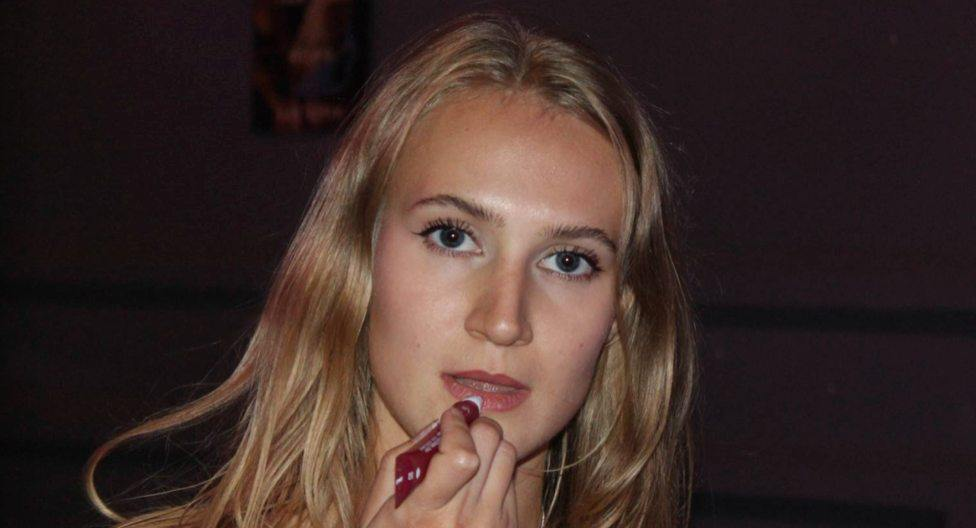
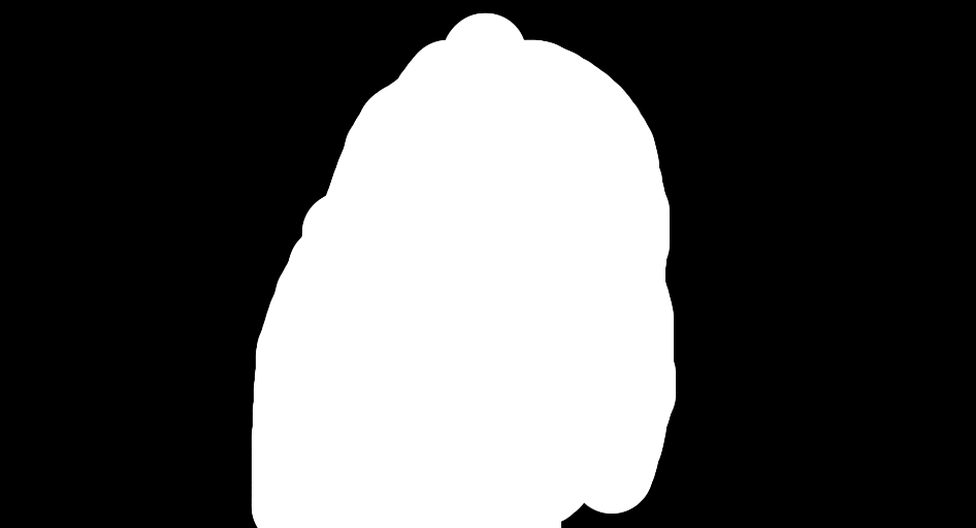

PuLID Applied
Seed: 13729330852581758745


  0%|          | 0/20 [00:00<?, ?it/s]

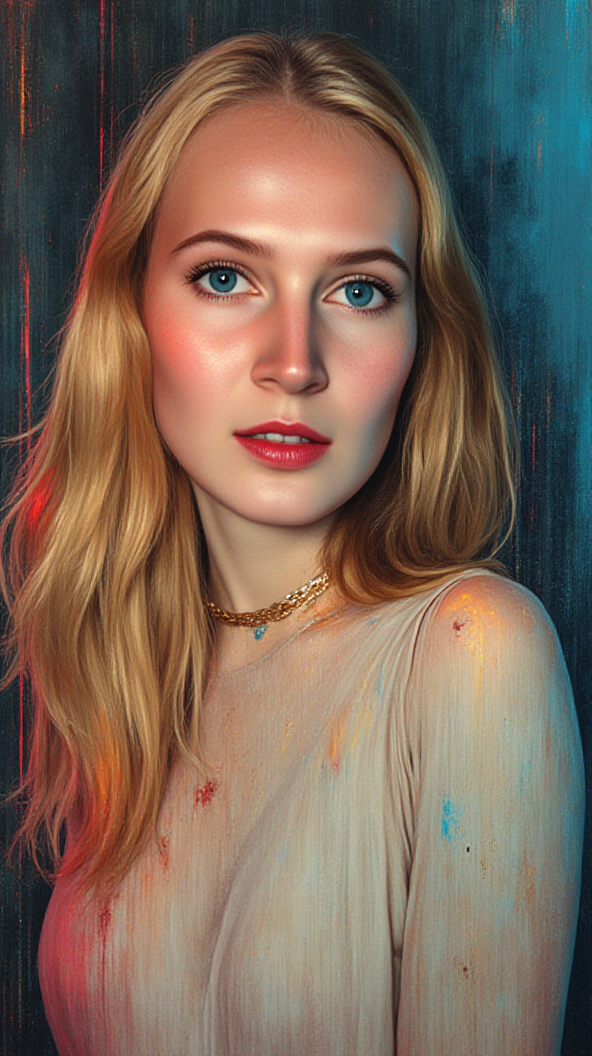

In [17]:
#@markdown <center><h1>Txt2Img</h1></center>

positive_prompt = "Incredibly photorealistic portrait of a cyberpunk suprematism beautiful blonde girl, digital art, by Stanley Artgerm Lau, WLOP, Rossdraws, James Jean, Andrei Riabovitchev, Marc Simonetti, Yoshitaka Amano. Rainbow. Maximalist.by Malevich. Suprematism calligraphy. Glitch. Webpunk Ultra realistic light. Cinematic light " # @param {"type":"string"}
width = 585 # @param {"type":"slider","min":256,"max":2048,"step":1}
height = 1051 # @param {"type":"slider","min":256,"max":2048,"step":1}
fixed_seed = 0 # @param {"type":"slider","min":0,"max":18446744073709552000,"step":1}
guidance = 3.5 # @param {"type":"slider","min":0,"max":20,"step":0.5}
steps = 20 # @param {"type":"slider","min":4,"max":50,"step":1}
sampler_name = "euler" # @param ["euler","heun","heunpp2","heunpp2","dpm_2","lms","dpmpp_2m","ipndm","deis","ddim","uni_pc","uni_pc_bh2"]
scheduler = "simple" # @param ["normal","sgm_uniform","simple","ddim_uniform"]
pulid_weight = 1 # @param {"type":"slider","min":-1,"max":5,"step":0.05}
pulid_start_at = 0.015 # @param {"type":"slider","min":0,"max":1,"step":0.001}
pulid_end_at = 1 # @param {"type":"slider","min":0,"max":1,"step":0.001}
batch_size = 1 # @param {"type":"slider","min":1,"max":20,"step":1}
auto_download = False # @param {"type":"boolean"}

generate(positive_prompt, width, height, fixed_seed, guidance, steps, sampler_name, scheduler, pulid_weight, pulid_start_at, pulid_end_at, batch_size, auto_download)

In [ ]:
#@markdown <center><h1>Img2Img</h1></center>

positive_prompt = "" # @param {"type":"string"}
fixed_seed = 0 # @param {"type":"slider","min":0,"max":18446744073709552000,"step":1}
guidance = 3.5 # @param {"type":"slider","min":0,"max":20,"step":0.5}
steps = 20 # @param {"type":"slider","min":4,"max":50,"step":1}
sampler_name = "euler" # @param ["euler","heun","heunpp2","heunpp2","dpm_2","lms","dpmpp_2m","ipndm","deis","ddim","uni_pc","uni_pc_bh2"]
scheduler = "simple" # @param ["normal","sgm_uniform","simple","ddim_uniform"]
input_img = "/content/test.png" # @param {"type":"string"}
denoise = 0.75 # @param {"type":"slider","min":0,"max":1,"step":0.01}
pulid_weight = 1 # @param {"type":"slider","min":-1,"max":5,"step":0.05}
pulid_start_at = 0.015 # @param {"type":"slider","min":0,"max":1,"step":0.001}
pulid_end_at = 1 # @param {"type":"slider","min":0,"max":1,"step":0.001}
batch_size = 1 # @param {"type":"slider","min":1,"max":20,"step":1}
auto_download = False # @param {"type":"boolean"}


generate(positive_prompt, 0, 0, fixed_seed, guidance, steps, sampler_name, scheduler, pulid_weight, pulid_start_at, pulid_end_at, batch_size, auto_download, "i2i", input_img, denoise)